# Introduction
The "Recommendation System for Spotify" project is focused on leveraging machine learning techniques to provide personalized music recommendations. The system will use a CSV file containing metadata for 150,000 songs to generate suggestions based on the user's musical preferences. At the start, users will input their musical tastes, and the system will propose songs tailored to those preferences. After listening to the recommended songs on Spotify, users can rate them on a scale from 0 to 5. These ratings will then be incorporated into the system to refine future recommendations, ensuring that the suggestions become more accurate as the user interacts with the system. This project aims to enhance the user experience by offering a dynamic, learning-based approach to music discovery.

In [108]:
import pandas as pd
import requests
import base64
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv('dataset.csv')
data

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,113995,2C3TZjDRiAzdyViavDJ217,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.2350,...,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,world-music
113996,113996,1hIz5L4IB9hN3WRYPOCGPw,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.1170,...,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,world-music
113997,113997,6x8ZfSoqDjuNa5SVP5QjvX,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.3290,...,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,world-music
113998,113998,2e6sXL2bYv4bSz6VTdnfLs,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.5060,...,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,world-music


## Comment
* **track_id**: The Spotify ID for the track
artists: The artists' names who performed the track. If there is more than one artist, they are separated by a ;
* **album_name**: The album name in which the track appears
* **track_name**: Name of the track
* **popularity**: The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
* **duration_ms**: The track length in milliseconds
* **explicit**: Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
* **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
* **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale
key: The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
* **loudness**: The overall loudness of a track in decibels (dB)
* **mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
* **speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
* **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
* **instrumentalness**: Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
* **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
* **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
* **tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
* **time_signature**: An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
* **track_genre**: The genre in which the track belongs


In [31]:
CLIENT_ID = '43d2468091bd42b89e3eee3d1ad005ba'
CLIENT_SECRET = 'bf22bc98b42a4016b6220487fe7f9821'

def get_access_token(client_id, client_secret):
    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": "Basic " + base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
    }
    data = {"grant_type": "client_credentials"}

    response = requests.post(url, headers=headers, data=data)
    response_data = response.json()
    return response_data.get("access_token")

# Get the access token
token = get_access_token(CLIENT_ID, CLIENT_SECRET)
print("Access Token:", token)

Access Token: BQDnud_gRcrw5Kza2hBzHA8RUXzlHayaFuHxk9kYmPi__YuJHFU5av-E55qb7hdb97rZNyKyw373hjSNfpo2HnHCrVH-_CLP86wVRq8iOh2kSKRV3WY


In [32]:
def get_tracks_urls(batch_ids):
    headers = {
        "Authorization": f"Bearer {token}"
    }
    SPOTIFY_API_BASE = "https://api.spotify.com/v1/tracks"
    ids_param = ",".join(batch_ids)  # Połącz ID w ciąg oddzielony przecinkami
    url = f"{SPOTIFY_API_BASE}?ids={ids_param}"
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        data = response.json()
        results = {}
        for track in data.get("tracks", []):
            if track:
                # Pobierz URL piosenki
                track_url = track.get("external_urls", {}).get("spotify", None)
                if track_url:
                    results[track["id"]] = track_url
        return results
    elif response.status_code == 429:  # Rate Limit Exceeded
        retry_after = int(response.headers.get("Retry-After", 5))  # Czas oczekiwania z nagłówka
        print(f"Rate limit exceeded. Waiting for {retry_after} seconds...")
        time.sleep(retry_after)
        return get_tracks_urls(batch_ids)  # Spróbuj ponownie
    else:
        print(f"Error {response.status_code}: {response.text}")
        return []

In [35]:
batch_size = 50
results = []
track_ids = data['track_id'].tolist()
url_mapping = {}  # Mapa track_id -> url

for i in range(110602, len(track_ids), batch_size):
    batch = track_ids[i:i + batch_size] # Pobierz kolejną partię track_id
    print(f"Processing batch {i // batch_size + 1} with {len(batch)} tracks...")
    batch_results = get_tracks_urls(batch)
    for track_id, url in batch_results.items():
        data.loc[data['track_id'] == track_id, 'url'] = url
    print(f"Processed {len(batch_results)} records so far. Waiting for 30 seconds...")
    time.sleep(0.4)  # Opóźnienie między partiami


print("URLs added to the DataFrame!")

Processing batch 2213 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2214 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2215 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2216 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2217 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2218 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2219 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2220 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2221 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2222 with 50 tracks...
Processed 50 records so far. Waiting for 30 seconds...
Processing batch 2223 with 50 tracks...
Processed 

In [88]:
data.to_csv("csv_with_urls.csv", index=False)
df=pd.read_csv("csv_with_urls.csv")

## Comment
Here, I used the Spotify API that returns me the URL to the every song. Please appreciate that I have done because I caused me a lot of effort because the API has the limit and I was able to send the request for only 50 tracks. With 115000 tracks and time limit on the requests, it took me 3 hours... :)

In [39]:
print(f'number of duplicate rows: {df.duplicated().sum()}\nnumber of null values:\n{df.isna().sum()}')

number of duplicate rows: 0
number of null values:
Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
url                 0
dtype: int64


In [41]:
null_artists = df.loc[pd.isna(df['artists'])]
null_artists

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,url
65900,65900,1kR4gIb7nGxHPI3D2ifs59,NaN,NaN,NaN,0,0,False,0.501,0.583,...,0,0.0605,0.69,0.00396,0.0747,0.734,138.391,4,k-pop,https://open.spotify.com/track/1kR4gIb7nGxHPI3...


In [42]:
df=df.dropna(subset=['artists'])

In [44]:
data.columns

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'url'],
      dtype='object')

In [ ]:
set_track_genre=set()
for genres in df['track_genre']:
    set_track_genre.add(genres)
map_track_genre={}
for i,genre in enumerate(set_track_genre, start=1):
    map_track_genre[genre]=i
df['track_genre_number']=df['track_genre'].map(map_track_genre)

In [ ]:
df['explicit']=df['explicit'].astype('int')

In [82]:
numeric_data=df.select_dtypes(include=['int64','float64'])
numeric_data.drop(['Unnamed: 0'],axis=1,inplace=True)
numeric_data


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre_number
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.7150,87.917,4,68
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.2670,77.489,4,68
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.1200,76.332,4,68
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.1430,181.740,3,68
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.1670,119.949,4,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.928000,0.0863,0.0339,125.995,5,70
113996,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.976000,0.1050,0.0350,85.239,4,70
113997,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.000000,0.0839,0.7430,132.378,4,70
113998,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.000000,0.2700,0.4130,135.960,4,70


# Exploratory Data Analysis

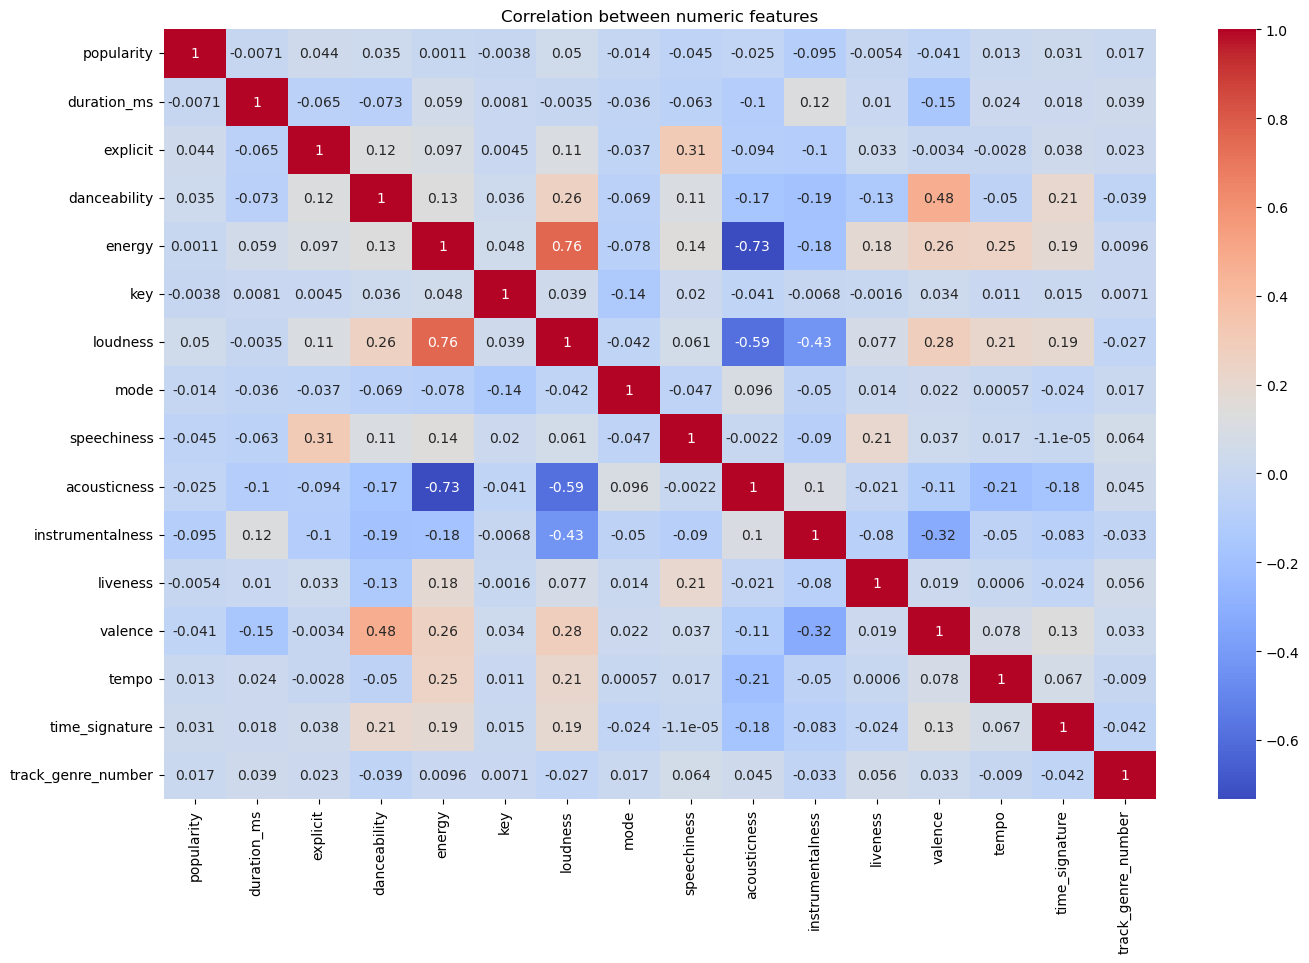

In [87]:
plt.figure(figsize=(16, 10))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between numeric features')
plt.show()

## Comment
Insights from the Correlation Matrix:
1. Energy and Loudness:
The strongest positive correlation is observed between energy and loudness, which is intuitive. Louder music tends to feel more energetic, creating a direct connection between these two features.
2. Valence with danceability, Energy, and Loudness:
Valence, which measures the happiness or positivity conveyed by the music, shows notable positive correlations with danceability, energy, and loudness. This indicates that happier songs are often more danceable, energetic, and loud, contributing to their overall upbeat nature. Such tracks tend to resonate well on dance floors or in lively settings.
3. Time Signature and danceability:
The correlation between time signature and danceability is intriguing. A consistent time signature can make a track easier to follow rhythmically, enhancing its suitability for dancing. Tracks with irregular time signatures may be less danceable due to their complex rhythms.
4. Acousticness and Energy:
A strong negative correlation (-0.73) exists between acousticness and energy. This suggests that acoustic tracks are generally less energetic, often emphasizing softer, more mellow tones instead of high-intensity beats.
5. Acousticness and Loudness:
The correlation between acousticness and loudness highlights that acoustic songs tend to be quieter. This aligns with the typical nature of acoustic music, which prioritizes subtlety and clarity over loudness.
6. Track Genre and Other Features:
Interestingly, track genre does not exhibit any significant correlation with other features. This suggests that genre alone may not directly dictate specific musical characteristics such as energy, danceability, or valence. Instead, genres might be more nuanced, capturing a broader range of musical diversity.

Text(0, 0.5, 'Energy')

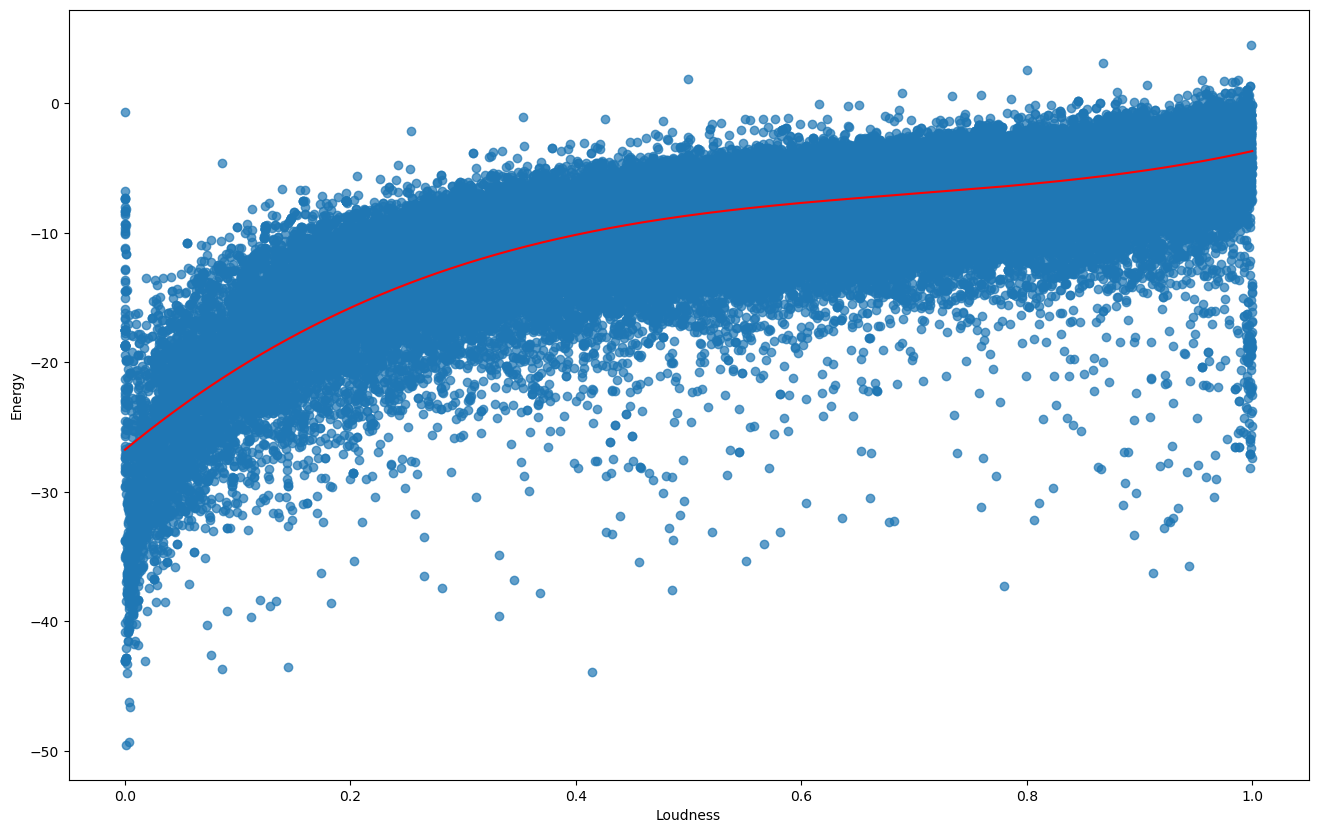

In [98]:
x=numeric_data['energy']
y=numeric_data['loudness']

degree=3
cooeficients=np.polyfit(x,y,degree)
polynomial=np.poly1d(cooeficients)

x_sorted=np.sort(x)
y_fit=polynomial(x_sorted)
plt.figure(figsize=(16, 10))
plt.scatter(x, y, alpha=0.7, label="Data points")
plt.plot(x_sorted, y_fit, color='red', label=f"Polynomial Regression (degree {degree})")
plt.xlabel('Loudness')
plt.ylabel('Energy')

Note: The loudness values are negative because they show how loud a song is compared to the maximum possible loudness (0 dB). Negative values mean the song is quieter than the maximum level, which is normal for most music. It helps keep the sound balanced and avoids distortion.

## Comment
A polynomial regression line of the third degree (shown in red) has been fitted to the data. The overall trend indicates that as the x-variable increases, the loudness tends to become less negative, reflecting higher loudness levels. However, there is a noticeable spread in the data points, suggesting significant variability in loudness for intermediate values of the x-variable. The fitted polynomial regression captures the general trend, but it may not fully explain the variability of the data.

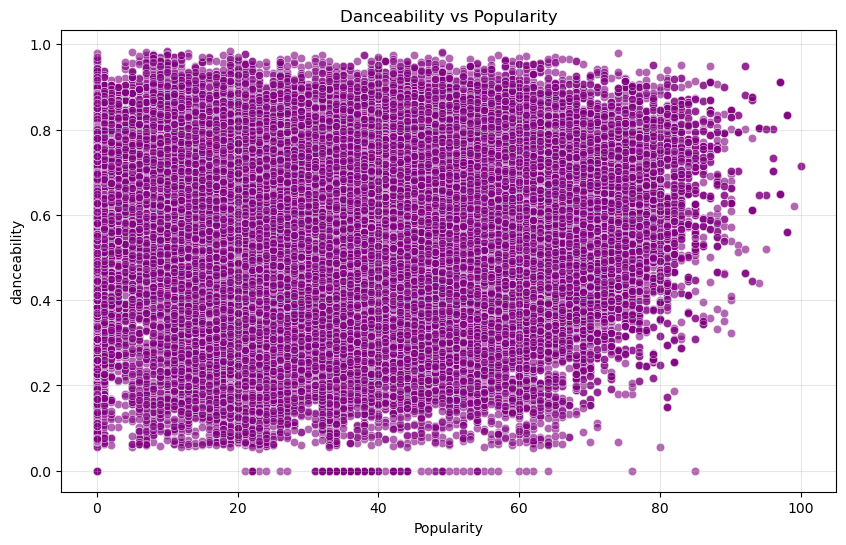

In [102]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='popularity', y='danceability', data=numeric_data, alpha=0.6, color='purple')
plt.title('Danceability vs Popularity')
plt.xlabel('Popularity')
plt.ylabel('danceability')
plt.grid(alpha=0.3)
plt.show()


## Comment

The relationship between danceability and popularity is intriguing, as it does not show a strong correlation. However, an interesting pattern emerges: after a popularity score of 60, there is a noticeable decrease in the number of low-danceability songs. Additionally, the most popular songs tend to have a danceability score above 50.

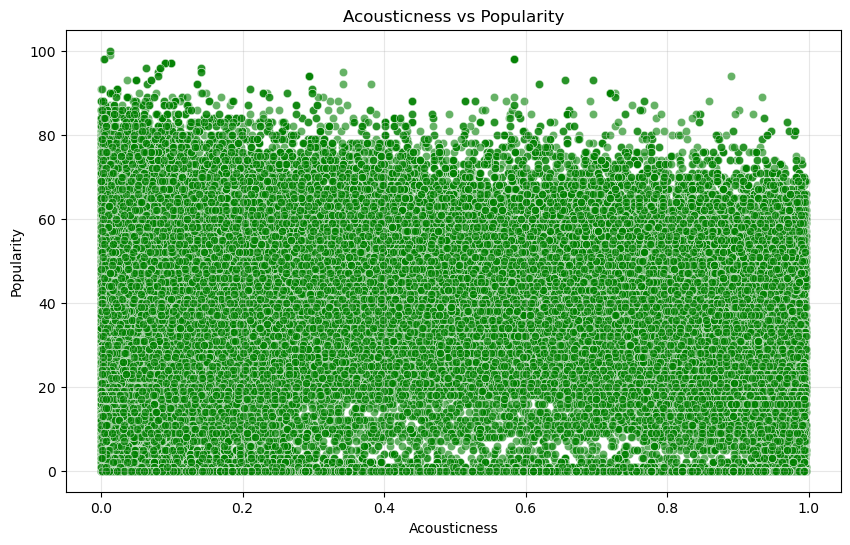

In [103]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='acousticness', y='popularity', data=data, alpha=0.6, color='green')
plt.title('Acousticness vs Popularity')
plt.xlabel('Acousticness')
plt.ylabel('Popularity')
plt.grid(alpha=0.3)
plt.show()


## Comment

There is an observable decreasing trend in acousticness with increasing popularity, indicating that the most popular songs (popularity score 80-100) are generally not acoustic. This suggests that listeners tend to prefer songs with less acoustic elements as their popularity grows, possibly favoring more energetic produced tracks.

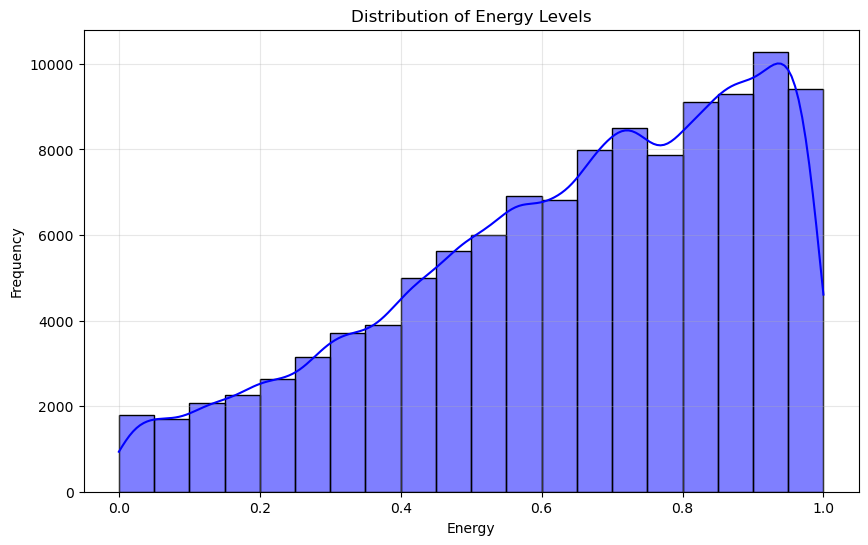

In [106]:
plt.figure(figsize=(10, 6))
sns.histplot(data['energy'], bins=20, kde=True, color='blue')
plt.title('Distribution of Energy Levels')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)
plt.show()


## Comment
As we can see, most songs tend to be more energetic, indicating that people are likely to prefer energetic tracks. This plot is particularly interesting because the distribution appears to follow a linear pattern with some noise. The linearity might be explained by the way energy is produced and measured in songs, as it often correlates with certain technical aspects like tempo, loudness, and instrumental arrangements. Producers and artists might also aim for a balanced range of energy levels to cater to diverse audience preferences while maintaining a structured progression in their music. This alignment could also reflect how listeners subconsciously gravitate toward songs with consistent energy trends across various genres.

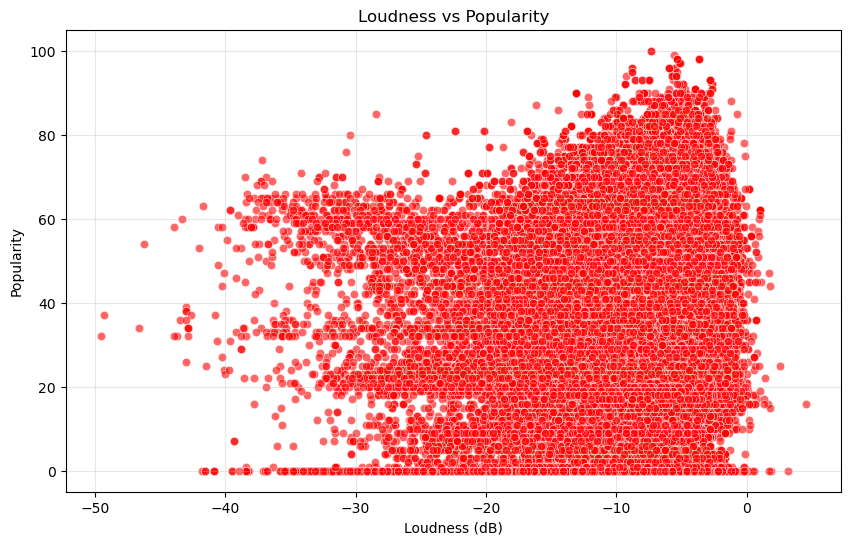

In [107]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='loudness', y='popularity', data=data, alpha=0.6, color='red')
plt.title('Loudness vs Popularity')
plt.xlabel('Loudness (dB)')
plt.ylabel('Popularity')
plt.grid(alpha=0.3)
plt.show()


## Comment

The distribution of points is quite intriguing and suggests the presence of interesting patterns. First, there is a notable concentration of songs with loudness between -40 and -30 dB that have a popularity score above 60. This implies that if you're creating a song that is quieter and slower, aiming for this loudness range might resonate well with listeners. On the other hand, the most popular songs tend to be much louder, typically falling within the range of -10 to 0 dB. Interestingly, there are no songs with loudness between -50 and -15 dB that achieve a popularity score above 90. This gap could indicate that songs in this intermediate range might lack the qualities—such as energy or clarity—that tend to appeal to a broader audience, highlighting the importance of fine-tuning loudness to match listener preferences.

# Data modeling

In [123]:
numeric_data_scaled=numeric_data.copy()
scaler = MinMaxScaler()
numeric_data_scaled=scaler.fit_transform(numeric_data_scaled)

song_lists=df['track_name']
song_URLs=df['url']

normalized_features = [ 'popularity','duration_ms', 'explicit', 'danceability', 'energy',
                        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
                        'track_genre_number']
#numeric_data

## Comment
Here, I normalized data using Min Max scaler. I believe that this is the best normalization method to all of this features because most of them have the range between 0 to 1

In [125]:

def get_user_preferences():
    print("Rate the following on a scale from 0 to 5:")
    preferences = {}
    preferences['danceability'] = float(input("Do you like danceable and energetic songs? (0-5): ")) / 5
    preferences['energy'] = preferences['danceability']
    preferences['loudness'] = float(input("Do you like loud songs? (0-5): ")) / 5
    preferences['valence'] = float(input("Do you prefer happy or sad songs? (valence) (0-5): ")) / 5
    preferences['acousticness'] = float(input("Do you like acoustic songs? (0-5): ")) / 5
    preferences['instrumentalness'] = preferences['acousticness']  # Powiązana cecha

    # Dla pozostałych cech ustaw neutralną wartość (np. 0.5 lub średnią z kolumny)
    for feature in normalized_features:
        if feature not in preferences:
            preferences[feature] = 0.5
    return preferences


user_preferences = get_user_preferences()
user_profile = np.array([user_preferences[feature] for feature in normalized_features]).reshape(1, -1)
user_profile


Rate the following on a scale from 0 to 5:


array([[0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.8, 0.5, 0.5, 0.4, 0.4, 0.5, 0.6,
        0.5, 0.5, 0.5]])

## Comment
I created a function that gives the basic knowledge about the preferences of the person, It will be used to find the best songs based also on it. In the uaer profile I stored the 2D table where I gathered the rating.

In [126]:
def recommend_cosine(data_normalized, user_profile, top_n=10):
    similarity = cosine_similarity(user_profile, data_normalized)
    indices = np.argsort(similarity[0])[::-1][:top_n]
    return indices

## Comment
Here, we have cosine_similarity method that createes a vector for the user and all the songs in the dataset and counts to cosine between them. The bigger the result is, the better the song fits to the person.

In [127]:
def recommend_knn(data_normalized, user_profile, top_n=10):
    knn=NearestNeighbors(n_neighbors=top_n,metric='kdi')
    knn.fit(data_normalized)
    distances,indices=knn.kneighbors(user_profile)
    return indices[0]

In [129]:
def recommend_pca(data_normalized,user_profile,top_n=10):
    pca=PCA(n_components=2)
    reduced_data=pca.fit_transform(data_normalized)
    reduced_user=pca.transform(user_profile)
    distances=np.linalg.norm(reduced_data-reduced_user,axis=1)
    indices = np.argsort(distances)[:top_n]
    return indices



In [130]:
def interactive_recommender(data_normalized, user_profile):
    print("Choose a recommendation method:")
    print("1. Cosine Similarity")
    print("2. K-Nearest Neighbors")
    print("3. PCA-Based")
    method = int(input("Enter method number (1-3): "))

    if method == 1:
        indices = recommend_cosine(data_normalized, user_profile)
    elif method == 2:
        indices = recommend_knn(data_normalized, user_profile)
    elif method == 3:
        indices = recommend_pca(data_normalized, user_profile)
    else:
        print("Invalid choice. Defaulting to Cosine Similarity.")
        indices = recommend_cosine(data_normalized, user_profile)

    print("\nRecommended Songs:")
    for i, idx in enumerate(indices):
        print(f"{i + 1}. {song_lists[idx]} - {song_URLs[idx]}")

    return indices

In [131]:
def feedback_loop(data_normalized, user_profile):
    while True:
        indices = interactive_recommender(data_normalized, user_profile)

        print("\nRate the recommended songs on a scale from 0 to 5:")
        user_feedback = []
        for idx in indices:
            rating = float(input(f"How do you rate '{song_lists[idx]}'? (0-5): "))
            user_feedback.append(rating / 5)

        # Update user profile based on feedback
        feedback_array = np.array(user_feedback).reshape(-1, 1)
        relevant_features = data_normalized.loc[indices, normalized_features].values
        user_profile = np.mean(np.vstack([user_profile, relevant_features * feedback_array]), axis=0).reshape(1, -1)

        print("\nUpdated recommendations based on your feedback:")
        continue_feedback = input("Would you like more recommendations? (yes/no): ").lower()
        if continue_feedback != 'yes':
            break

In [132]:
feedback_loop(numeric_data_scaled, user_profile)

Choose a recommendation method:
1. Cosine Similarity
2. K-Nearest Neighbors
3. PCA-Based

Recommended Songs:
1. Isso É Porte de Bandido - https://open.spotify.com/track/0JBlB87v8DaQS60V7m3T7V
2. Bonde do Tony Country - https://open.spotify.com/track/3CgbPnDAJxz43kjGs4NMZY
3. MONTAGEM COCOTA FEIA PRA CARALHO - https://open.spotify.com/track/64XhWxwgpjs4OtTgOlBfZt
4. Fake Love Song - https://open.spotify.com/track/3C257gmlEPezuzwp137b22
5. Running in Blind (Gojo Rap) - https://open.spotify.com/track/01YYvokYa6Cmmk8lBf65iT
6. PAI VAI TI PAPA - https://open.spotify.com/track/4vP2nMFiFNbQMqnJIT45CR
7. Terrorist Threats - https://open.spotify.com/track/2BaSlRAT2nI6M7lU5XJDZY
8. Juicy - 2005 Remaster - https://open.spotify.com/track/5ByAIlEEnxYdvpnezg7HTX
9. Mundo Moderno - https://open.spotify.com/track/63TXrgCBFVP2NDTZepoFCy
10. hurt myself - https://open.spotify.com/track/4Pxi7M3fCCBDG0EfC17eHw

Rate the recommended songs on a scale from 0 to 5:


KeyboardInterrupt: Interrupted by user